In [393]:
import numpy as np
from matplotlib import pyplot as plt

from snn.layers import SCTNLayer
from snn.resonator import lp_by_lf
from snn.spiking_network import SpikingNetwork
from snn.spiking_neuron import create_SCTN, IDENTITY


def neuron_output(neuron, signal_freq, shift_degrees=0, phase_number=2):
    y_events = neuron.out_spikes()
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > ((phase_number-1)/signal_freq) * clk_freq + shift_samples) &
        (y_events < ((phase_number/signal_freq) * clk_freq) + shift_samples)
    ]
    if len(y_events) == 0:
        return y_events
    y_events -= int(((phase_number-1)/signal_freq) * clk_freq + shift_samples)
    return y_events

def events_to_spikes(events, run_window=0, spikes_arr_size=-1):
    if spikes_arr_size == -1:
        y_spikes = np.zeros(events[-1] + 1)
    else:
        y_spikes = np.zeros(spikes_arr_size)

    y_spikes[events] = 1
    if run_window == 0:
        return y_spikes

    y_spikes_rollsum = np.convolve(y_spikes, np.ones(run_window, dtype=int), 'valid')
    return y_spikes_rollsum

def amplify_spikes(base_spikes, spikes_window, base_min, base_max, amplify):
    base_spikes = events_to_spikes(base_spikes-resonator_input[0], spikes_arr_size=int(clk_freq/freq0))
    result = np.zeros_like(base_spikes)
    result[np.arange(len(base_spikes)) % 2 == 1] = 1
    dc = (base_max + base_min)/2
    for i in range(spikes_window, len(result), spikes_window):
        slice_spikes = base_spikes[i:i+spikes_window]
        if len(slice_spikes) < spikes_window:
            break
        curr_spikes = np.sum(slice_spikes) - dc
        new_spikes = int(curr_spikes * amplify)

        if new_spikes > 0:
            spikes_ts = np.linspace(0, spikes_window, new_spikes).astype(int)//2*2 + i
            result[spikes_ts] = 1
        else:
            spikes_ts = np.linspace(0, spikes_window, abs(new_spikes)).astype(int)//2*2 - 1 + i
            result[spikes_ts] = 0
    result = np.where(result == 1)[0]
    return result

def smooth(arr, size):
    filter = np.exp(-(np.arange(size) - size//2)**2 / (2 * (size/4)**2))
    normalized_filter = filter / np.sum(filter)
    res = np.convolve(arr, normalized_filter, 'same')
    res[:size] = arr[:size]
    res[-size:] = arr[-size:]
    return res

clk_freq = 1536000
duration = .25
freq0 = 104

x = np.linspace(0, duration, int(duration * clk_freq))
t = x * 2 * np.pi * freq0
sine_wave = np.sin(t)

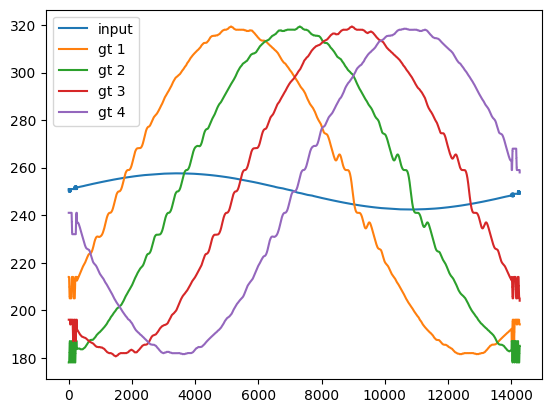

In [379]:
%matplotlib inline

spikes_window = 500
resonator = SpikingNetwork(clk_freq)
resonator.add_amplitude(1000)

# Encode to pdm
neuron = create_SCTN()
neuron.activation_function = IDENTITY
resonator.add_layer(SCTNLayer([neuron]))

wave_length = int(clk_freq/freq0)
resonator.input_full_data(sine_wave[:19*wave_length])
resonator.log_out_spikes(-1)
resonator.forget_logs()

gt_rand_gauss_var = resonator.neurons[0].rand_gauss_var
gt_membrane_potential = resonator.neurons[0].membrane_potential
resonator.input_full_data(sine_wave[:2*wave_length])

resonator_input = neuron_output(resonator.neurons[0], freq0, shift_degrees=0)
rresonator_input = events_to_spikes(resonator_input-resonator_input[0], run_window=16, spikes_arr_size=int(clk_freq/freq0))

gt1 = neuron_output(resonator.neurons[0], freq0, shift_degrees=-45)
gt1 = amplify_spikes(gt1, 16, rresonator_input.min(), rresonator_input.max(), 10)

gt2 = neuron_output(resonator.neurons[0], freq0, shift_degrees=-90)
gt2 = amplify_spikes(gt2, 16, rresonator_input.min(), rresonator_input.max(), 10)

gt3 = neuron_output(resonator.neurons[0], freq0, shift_degrees=-135)
gt3 = amplify_spikes(gt3, 16, rresonator_input.min(), rresonator_input.max(), 10)

gt4 = neuron_output(resonator.neurons[0], freq0, shift_degrees=-180)
gt4 = amplify_spikes(gt4, 16, rresonator_input.min(), rresonator_input.max(), 10)

ground_truth = [gt1, gt2, gt3, gt4]
rolling_gt = []
plt.plot(smooth(events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)), 256), label=f'input')
for i, gt in enumerate(ground_truth):
    rolling_gt.append(smooth(events_to_spikes(gt-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)), 256))
    plt.plot(rolling_gt[i], label=f'gt {i+1}')
plt.legend()

In [380]:
def learning_resonator(
        lf,
        thetas,
        weights,
        ground_truths,
        A,
        time_to_learn,
        max_weight,
        min_weight,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    tau = network.clk_freq * time_to_learn / 2
    network.add_amplitude(1000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    neuron.set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[0])
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        neuron.set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[1 + i])
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def simple_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

## Weights Learning

In [383]:
l = min([resonator_input[-1], gt4[-1]])

def flat_weights(resonator):
    ws = []
    for neuron in resonator.neurons[1:]:
        for w in neuron.synapses_weights:
            ws.append(abs(float(f'{w:.3f}')))
    return np.array(ws)

def flat_thetas(resonator):
    return [float(f'{neuron.theta:.3f}') for neuron in resonator.neurons[1:]]

def calculate_miss_spikes(neuron):
    total_miss_spikes = 0
    if neuron.supervised_stdp is not None:
        out_spikes = neuron.out_spikes()
        gt = neuron.supervised_stdp.desired_output
        out_spikes = out_spikes[(out_spikes >= gt[0]) & (out_spikes <= gt[-1])]
        total_miss_spikes = len(gt) - (len(set(out_spikes) & set(gt)))
    return total_miss_spikes


def calculate_extra_spikes(neuron):
    extra_spikes = 0
    if neuron.supervised_stdp is not None:
        out_spikes = neuron.out_spikes()
        gt = neuron.supervised_stdp.desired_output
        out_spikes = out_spikes[(out_spikes >= gt[0]) & (out_spikes <= gt[-1])]
        extra_spikes = len(out_spikes) - (len(set(out_spikes) & set(gt)))
    return extra_spikes

In [382]:
resonator = learning_resonator(
    lf=5,
    thetas=[-1, -5, -5, -5],
    weights=np.random.random(5)*5 + 7,
    ground_truths=[gt1, gt2, gt3, gt4],
    A=1e-4,
    time_to_learn=1e-5,
    max_weight=15,
    min_weight=-15,
)
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)

In [386]:
%matplotlib notebook
epochs = 50

weights = np.zeros((epochs+1, 5))
weights[0, :] = flat_weights(resonator)

miss_spikes = np.zeros((epochs+1, 4))
miss_spikes[0, :] = np.array([len(gt)/1000 for gt in ground_truth])

extra_spikes = np.zeros((epochs+1, 4))
extra_spikes[0, :] = np.array([len(gt)/1000 for gt in ground_truth])

mses = np.zeros((epochs+1, 4))
mses[0, :] = np.array([(gt**2).mean() for gt in ground_truth])

fig, axs = plt.subplots(4, 1, figsize=(12, 6))
axs[0].set_title('weights')
axs[0].set_xlim(0, epochs+1)
lines = [axs[0].plot([w], label=f'weight {i}')[0] for i, w in enumerate(weights[0])]

axs[1].set_title('phase output')
axs[1].set_xlim(gt1[0]-resonator_input[0], gt1[-1]-resonator_input[0])
axs[1].set_ylim(0, spikes_window)
phase_lines = [axs[1].plot(gt, label=f'output neuron {i}')[0] for i, gt in enumerate(rolling_gt)]

axs[2].set_title('spikes misses')
axs[2].set_xlim(0, epochs+1)
axs[2].set_ylim(0, 8)
miss_spikes_lines = [axs[2].plot([ms], label=f'miss spikes {i}', marker='v')[0] for i, ms in enumerate(miss_spikes[0])]
extra_spikes_lines = [axs[2].plot([es], label=f'extra spikes {i}', marker='+')[0] for i, es in enumerate(extra_spikes[0])]

axs[3].set_title('mse')
axs[3].set_xlim(0, epochs+1)
axs[3].set_ylim(0, 10000)
mse_lines = [axs[3].plot([mse], label=f'mse {i}', marker='+')[0] for i, mse in enumerate(mses[0])]
fig.tight_layout()

for i in range(1, epochs+1):

    for neuron in resonator.neurons:
        # neuron.rand_gauss_var = 0
        # neuron.membrane_potential = 0.0
        neuron.rand_gauss_var = gt_rand_gauss_var
        neuron.membrane_potential = gt_membrane_potential

    resonator.input_full_data(sine_wave[:wave_length])

    # weights chart
    weights[i, :] = flat_weights(resonator)

    # min_y, max_y = 15, 0
    for j, line in enumerate(lines):
        line.set_xdata(np.arange(i))
        line.set_ydata(weights[:i, j])
    max_y = 1.1*weights[max(0, i-4):i+1, :].max()
    min_y = 0.9*weights[max(0, i-4):i+1, :].min()
    axs[0].set_ylim(min_y, max_y)

    # phase chart
    min_y, max_y = spikes_window, 0
    output = [events_to_spikes(neuron_output(neuron, freq0, phase_number=1)-resonator_input[0],
                               run_window=spikes_window,
                               spikes_arr_size=int(clk_freq/freq0))
              for neuron in resonator.neurons[1:]]
    for j, o in enumerate(output):
        phase_lines[j].set_xdata(np.linspace(0, gt1[-1]-resonator_input[0], len(o)))
        phase_lines[j].set_ydata(o)
        min_y = np.min([min_y, o.min()])
        max_y = np.max([max_y, o.max()])
    axs[1].set_ylim(min_y, max_y)

    # miss spikes chart
    for j, neuron in enumerate(resonator.neurons[1:]):
        miss_spikes[i, j] = calculate_miss_spikes(neuron)/1000
        extra_spikes[i, j] = calculate_extra_spikes(neuron)/1000

    for j, line in enumerate(miss_spikes_lines):
        line.set_xdata(np.arange(i))
        line.set_ydata(miss_spikes[:i, j])
    for j, line in enumerate(extra_spikes_lines):
        line.set_xdata(np.arange(i))
        line.set_ydata(extra_spikes[:i, j])

    # mse
    max_y = 0
    mses[i, :] = [((gt - o)**2).mean() for gt, o in zip(rolling_gt, output)]
    for j, line in enumerate(mse_lines):
        line.set_xdata(np.arange(i))
        line.set_ydata(mses[:i, j])
        max_y = np.max([max_y, 1.5*mses[max(0, i-4):i+1, j].max()])
    axs[3].set_ylim(0, max_y)


    for j in range(4):
        axs[j].legend(loc='right')

    fig.canvas.draw()
    fig.canvas.flush_events()

    resonator.forget_logs()

<IPython.core.display.Javascript object>

In [387]:
chosen_weights = weights[mses.sum(axis=1).argmin()]
chosen_weights

array([11.219,  9.458,  9.934, 10.018, 10.065])

In [390]:
%matplotlib inline

res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=5,
    thetas=flat_thetas(resonator),
    weights=chosen_weights,
    # thetas=[-1, -5, -5, -5],
    # weights=[11, 9, 10, 10, 10],
)

for i in range(len(res_resonator.neurons)):
    res_resonator.log_out_spikes(i)
res_resonator.input_full_data(sine_wave)

output = [events_to_spikes(neuron_output(neuron, freq0, phase_number=20), run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1) for neuron in res_resonator.neurons]

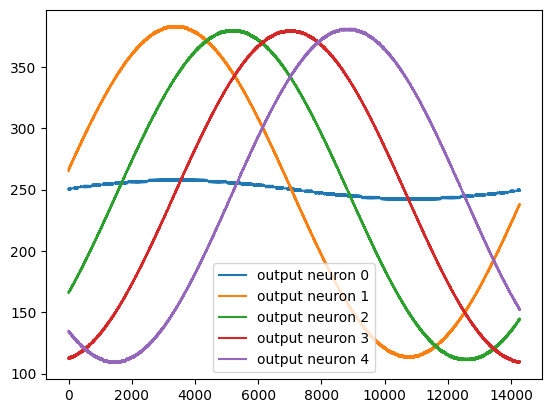

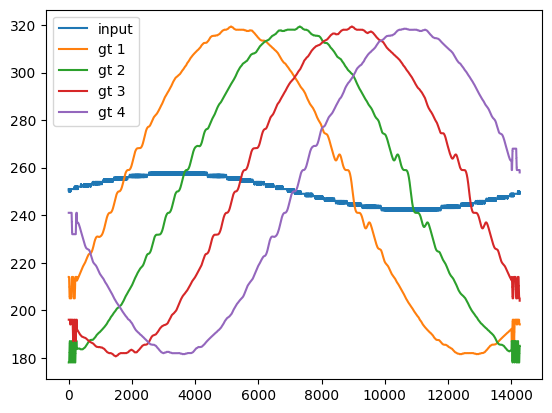

In [391]:
%matplotlib inline

for i, o in enumerate(output):
    plt.plot(o, label=f'output neuron {i}')
plt.legend()
plt.show()

plt.plot(events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window), label=f'input')
for i, gt in enumerate(rolling_gt):
    plt.plot(gt, label=f'gt {i+1}')

plt.legend()

peak: 107.21764336799086


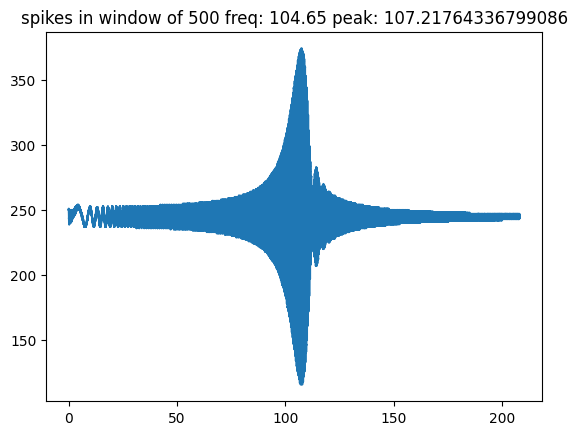

In [392]:
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=5,
    thetas=flat_thetas(resonator),
    # weights=[11, 9, 10, 10, 10],
    weights=chosen_weights,
)

res_resonator.log_out_spikes(-1)

start_freq = 0
spectrum = 2 * freq0
res_resonator.forget_logs()

step = 1 / 40000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)
spikes_window_size = 500
spikes_neuron = res_resonator.neurons[-1]
y_events = spikes_neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[y_events] = 1
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
print(f'peak: {x[1000+np.argmax(y_spikes[1000:])]}')

best_lp = lp_by_lf(5, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, 5, best_lp)
plt.title(f'spikes in window of {spikes_window_size} freq: {f_resonator:.2f} peak: {x[1000+np.argmax(y_spikes[1000:])]}')
plt.plot(x, y_spikes)
plt.show()

## Bias Learning

In [405]:
%matplotlib inline

resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=5,
    thetas=-np.random.rand(4)*7,
    # weights=chosen_weights,
    # thetas=[-1, -5, -5, -5],
    weights=[11, 9, 10, 10, 10],
)

for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)

In [410]:
%matplotlib notebook
epochs = 1000

biases = np.zeros((epochs+1, 4))
biases[0, :] = flat_thetas(resonator)

mses = np.zeros((epochs+1, 4))
mses[0, :] = np.array([(gt**2).mean() for gt in ground_truth])

fig, axs = plt.subplots(3, 1, figsize=(12, 4))
axs[0].set_title('biases')
axs[0].set_xlim(0, epochs+1)
lines = [axs[0].plot([w], label=f'bias {i}')[0] for i, w in enumerate(biases[0])]

axs[1].set_title('phase output')
axs[1].set_xlim(gt1[0]-resonator_input[0], gt1[-1]-resonator_input[0])
axs[1].set_ylim(0, spikes_window)
phase_lines = [axs[1].plot(gt, label=f'output neuron {i}')[0] for i, gt in enumerate(rolling_gt)]

axs[2].set_title('mse')
axs[2].set_xlim(0, epochs+1)
axs[2].set_ylim(0, 10000)
mse_lines = [axs[2].plot([mse], label=f'mse {i}', marker='+')[0] for i, mse in enumerate(mses[0])]
fig.tight_layout()

for i in range(1, epochs+1):

    for neuron in resonator.neurons:
        neuron.rand_gauss_var = gt_rand_gauss_var
        neuron.membrane_potential = gt_membrane_potential

    resonator.input_full_data(sine_wave[:wave_length])

    # phase chart
    min_y, max_y = spikes_window, 0
    output = [events_to_spikes(neuron_output(neuron, freq0, phase_number=1)-resonator_input[0],
                               run_window=spikes_window,
                               spikes_arr_size=int(clk_freq/freq0))
              for neuron in resonator.neurons[1:]]
    for j, o in enumerate(output):
        phase_lines[j].set_xdata(np.linspace(0, gt1[-1]-resonator_input[0], len(o)))
        phase_lines[j].set_ydata(o)
        min_y = np.min([min_y, o.min()])
        max_y = np.max([max_y, o.max()])
    axs[1].set_ylim(min_y, max_y)

    # biases chart
    biases[i, :] = flat_thetas(resonator)
    for j, line in enumerate(lines):
        line.set_xdata(np.arange(i))
        line.set_ydata(biases[:i, j])
    max_y = 1.1*biases[:i+1, :].max()
    min_y = 1.1*biases[:i+1, :].min()
    axs[0].set_ylim(min_y, max_y)
    bias_shift = [-np.arctan((np.mean(o) - spikes_window/2)/(20*spikes_window)) for o in output]
    for bs, neuron in zip(bias_shift, resonator.neurons[1:]):
        neuron.theta += bs

    # mse
    max_y = 0
    mses[i, :] = [((gt - o)**2).mean() for gt, o in zip(rolling_gt, output)]
    for j, line in enumerate(mse_lines):
        line.set_xdata(np.arange(i))
        line.set_ydata(mses[:i, j])
        max_y = np.max([max_y, 1.5*mses[max(0, i-4):i+1, j].max()])
    axs[2].set_ylim(0, max_y)


    for j in range(3):
        axs[j].legend(loc='right')

    fig.canvas.draw()
    fig.canvas.flush_events()

    resonator.forget_logs()

<IPython.core.display.Javascript object>

In [411]:
chosen_bias = biases[mses.sum(axis=1).argmin()]
chosen_bias

array([-0.739, -5.048, -5.336, -5.451])

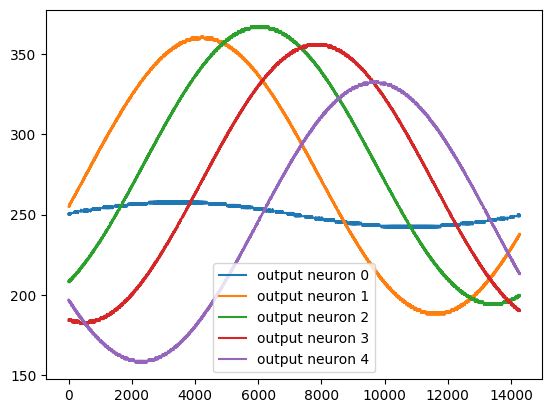

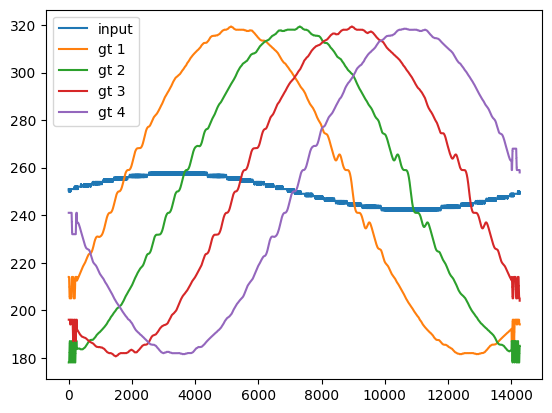

In [413]:
%matplotlib inline

res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=5,
    thetas=chosen_bias,
    weights=[11, 9, 10, 10, 10],
)

for i in range(len(res_resonator.neurons)):
    res_resonator.log_out_spikes(i)
res_resonator.input_full_data(sine_wave)

output = [events_to_spikes(neuron_output(neuron, freq0, phase_number=20), run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1) for neuron in res_resonator.neurons]
%matplotlib inline

for i, o in enumerate(output):
    plt.plot(o, label=f'output neuron {i}')
plt.legend()
plt.show()

plt.plot(events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window), label=f'input')
for i, gt in enumerate(rolling_gt):
    plt.plot(gt, label=f'gt {i+1}')

plt.legend()

peak: 107.21441817416911


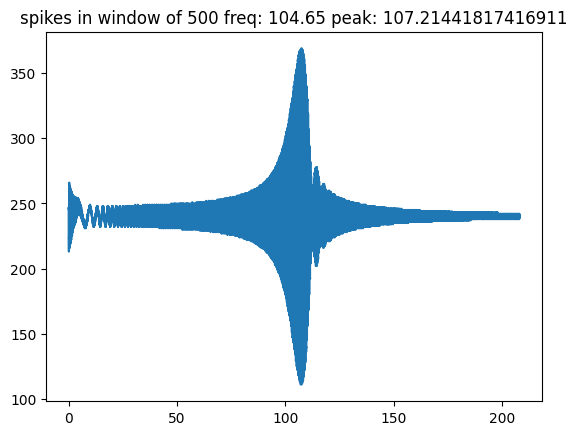

In [416]:
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=5,
    thetas=chosen_bias,
    # weights=[11, 9, 10, 10, 10],
    weights=chosen_weights,
)

res_resonator.log_out_spikes(-1)

start_freq = 0
spectrum = 2 * freq0
res_resonator.forget_logs()

step = 1 / 40000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)
spikes_window_size = 500
spikes_neuron = res_resonator.neurons[-1]
y_events = spikes_neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[y_events] = 1
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
print(f'peak: {x[1000+np.argmax(y_spikes[1000:])]}')

best_lp = lp_by_lf(5, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, 5, best_lp)
plt.title(f'spikes in window of {spikes_window_size} freq: {f_resonator:.2f} peak: {x[1000+np.argmax(y_spikes[1000:])]}')
plt.plot(x, y_spikes)
plt.show()

In [415]:
chosen_bias

array([-0.739, -5.048, -5.336, -5.451])

## Bias + Weights Learning

In [487]:
resonator = learning_resonator(
    lf=5,
    thetas=-np.random.random(4)*10,
    weights=np.random.random(5)*5 + 7,
    ground_truths=[gt1, gt2, gt3, gt4],
    A=1e-4,
    time_to_learn=1e-5,
    max_weight=15,
    min_weight=-15,
)
learning_rules = [neuron.supervised_stdp for neuron in resonator.neurons[1:]]
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)

In [488]:
%matplotlib notebook
epochs = 3000

weights = np.zeros((epochs+1, 5))
weights[0, :] = flat_weights(resonator)

biases = np.zeros((epochs+1, 4))
biases[0, :] = flat_thetas(resonator)

mses = np.zeros((epochs+1, 4))
mses[0, :] = np.array([(gt**2).mean() for gt in ground_truth])

fig, axs = plt.subplots(4, 1, figsize=(12, 6))
axs[0].set_title('weights')
axs[0].set_xlim(0, epochs+1)
weights_lines = [axs[0].plot([w], label=f'weight {i}')[0] for i, w in enumerate(weights[0])]


axs[1].set_title('biases')
axs[1].set_xlim(0, epochs+1)
biases_lines = [axs[1].plot([w], label=f'bias {i}')[0] for i, w in enumerate(biases[0])]

axs[2].set_title('phase output')
axs[2].set_xlim(gt1[0]-resonator_input[0], gt1[-1]-resonator_input[0])
axs[2].set_ylim(0, spikes_window)
phase_lines = [axs[2].plot(gt, label=f'output neuron {i}')[0] for i, gt in enumerate(rolling_gt)]

axs[3].set_title('mse')
axs[3].set_xlim(0, epochs+1)
axs[3].set_ylim(0, 10000)
mse_lines = [axs[3].plot([mse], label=f'mse {i}', marker='+')[0] for i, mse in enumerate(mses[0])]
fig.tight_layout()

for i in range(1, epochs+1):
    if i % 200 == 0 and i > 600:
        for lr, neuron in zip(learning_rules, resonator.neurons[1:]):
            neuron.supervised_stdp = lr
    else:
        for neuron in resonator.neurons[1:]:
            neuron.supervised_stdp = None

    for neuron in resonator.neurons:
        neuron.rand_gauss_var = gt_rand_gauss_var
        neuron.membrane_potential = gt_membrane_potential

    resonator.input_full_data(sine_wave[:wave_length])

    # weights chart
    weights[i, :] = flat_weights(resonator)

    for j, line in enumerate(weights_lines):
        line.set_xdata(np.arange(i))
        line.set_ydata(weights[:i, j])
    max_y = 1.1*weights[max(0, i-4):i+1, :].max()
    min_y = 0.9*weights[max(0, i-4):i+1, :].min()
    axs[0].set_ylim(min_y, max_y)

    # phase chart
    min_y, max_y = spikes_window, 0
    output = [events_to_spikes(neuron_output(neuron, freq0, phase_number=1)-resonator_input[0],
                               run_window=spikes_window,
                               spikes_arr_size=int(clk_freq/freq0))
              for neuron in resonator.neurons[1:]]
    for j, o in enumerate(output):
        phase_lines[j].set_xdata(np.linspace(0, gt1[-1]-resonator_input[0], len(o)))
        phase_lines[j].set_ydata(o)
        min_y = np.min([min_y, o.min()])
        max_y = np.max([max_y, o.max()])
    axs[2].set_ylim(min_y, max_y)

    # biases chart
    biases[i, :] = flat_thetas(resonator)
    for j, line in enumerate(biases_lines):
        line.set_xdata(np.arange(i))
        line.set_ydata(biases[:i, j])
    max_y = 1.1*biases[:i+1, :].max()
    min_y = 1.1*biases[:i+1, :].min()
    axs[1].set_ylim(min_y, max_y)
    # bias_shift = [-np.arctan((np.mean(o) - spikes_window/2)/(10*spikes_window)) for o in output]
    bias_shift = [-((2*np.mean(o) - spikes_window)/(spikes_window))**3 for o in output]
    for bs, neuron in zip(bias_shift, resonator.neurons[1:]):
        neuron.theta += bs

    # mse
    max_y = 0
    mses[i, :] = [((gt - o)**2).mean() for gt, o in zip(rolling_gt, output)]
    for j, line in enumerate(mse_lines):
        line.set_xdata(np.arange(i))
        line.set_ydata(mses[:i, j])
        max_y = np.max([max_y, 1.5*mses[max(0, i-4):i+1, j].max()])
    axs[3].set_ylim(0, max_y)


    for j in range(4):
        axs[j].legend(loc='right')

    fig.canvas.draw()
    fig.canvas.flush_events()

    resonator.forget_logs()

<IPython.core.display.Javascript object>

In [489]:
print(f'min mse {mses.sum(axis=1).argmin()}')
chosen_bias = biases[mses.sum(axis=1).argmin()]
chosen_weights = weights[mses.sum(axis=1).argmin()]
np.concatenate([chosen_bias, chosen_weights])

min mse 547


array([ 0.172, -4.967, -4.431, -5.894,  9.02 ,  8.607,  9.948,  8.332,
       10.842])

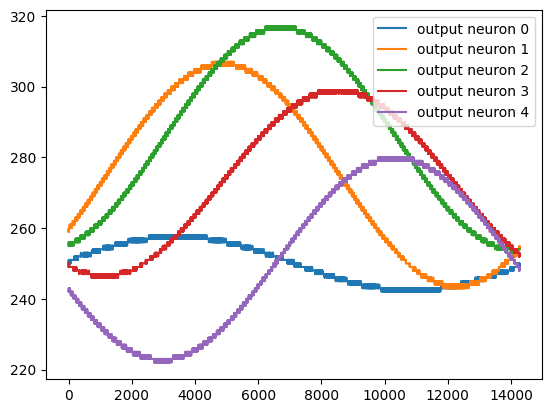

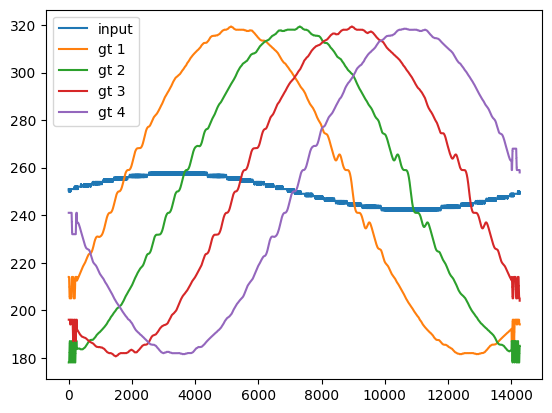

In [490]:
%matplotlib inline

res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=5,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for i in range(len(res_resonator.neurons)):
    res_resonator.log_out_spikes(i)
res_resonator.input_full_data(sine_wave)

output = [events_to_spikes(neuron_output(neuron, freq0, phase_number=20), run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1) for neuron in res_resonator.neurons]
%matplotlib inline

for i, o in enumerate(output):
    plt.plot(o, label=f'output neuron {i}')
plt.legend()
plt.show()

plt.plot(events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window), label=f'input')
for i, gt in enumerate(rolling_gt):
    plt.plot(gt, label=f'gt {i+1}')

plt.legend()

peak: 98.59562521786164


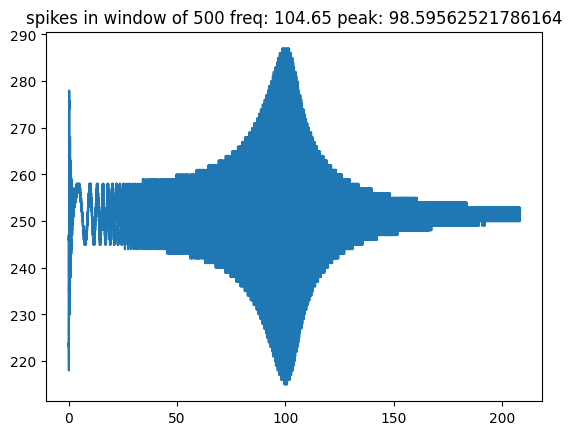

In [491]:
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=5,
    thetas=chosen_bias,
    weights=chosen_weights,
)

res_resonator.log_out_spikes(-1)

start_freq = 0
spectrum = 2 * freq0
res_resonator.forget_logs()

step = 1 / 40000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)
spikes_window_size = 500
spikes_neuron = res_resonator.neurons[-1]
y_events = spikes_neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[y_events] = 1
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
print(f'peak: {x[1000+np.argmax(y_spikes[1000:])]}')

best_lp = lp_by_lf(5, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, 5, best_lp)
plt.title(f'spikes in window of {spikes_window_size} freq: {f_resonator:.2f} peak: {x[1000+np.argmax(y_spikes[1000:])]}')
plt.plot(x, y_spikes)
plt.show()